IMPORTAÇÃO DAS BIBLIOTECAS

In [85]:
import numpy as np
import pandas as pd
import datetime
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

IMPORTAÇÃO DOS DATASETS

In [176]:
orders_df=pd.read_csv('dataset/olist_orders_dataset.csv')
customers_df=pd.read_csv('dataset/olist_customers_dataset.csv')
seller_df=pd.read_csv('dataset/olist_sellers_dataset.csv')
items_df=pd.read_csv('dataset/olist_order_items_dataset.csv')
products_df=pd.read_csv('dataset/olist_products_dataset.csv')
product_tr=pd.read_csv('dataset/product_category_name_translation.csv')
order_pay = pd.read_csv("dataset/olist_order_payments_dataset.csv")

TRADUÇÃO DOS NOMES DOS PRODUTOS PARA O INGLES

In [108]:
category_translations = dict(zip(product_tr['product_category_name'],product_tr['product_category_name_english']))
products_df = products_df.replace({'product_category_name':category_translations})

MESCLAR TODOS OS DATASETS EM APENAS 1

In [177]:
merge_df=pd.merge(customers_df.drop(['customer_zip_code_prefix'], axis=1), 
                              orders_df.drop(['order_approved_at','order_delivered_carrier_date'],axis=1), how='outer',left_on='customer_id',right_on='customer_id')
merge_df=pd.merge(merge_df, items_df[['order_id','product_id', 'seller_id','price', 'freight_value']], on='order_id')
merge_df=pd.merge(merge_df, seller_df[['seller_id', 'seller_state']], on='seller_id')
merge_df=pd.merge(merge_df, order_pay[['order_id', 'payment_type']], on='order_id')
merge_df=pd.merge(merge_df, products_df[['product_id','product_category_name','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']])
merge_df=merge_df.dropna()

CONVERTER AS COLUNAS DATA PARA TIMESTAMP

In [127]:
order_date=['order_purchase_timestamp', u'order_approved_at',
            u'order_delivered_carrier_date', u'order_delivered_customer_date',
            u'order_estimated_delivery_date']
for items in order_date:
    merge_df[items] = pd.to_datetime(orders_df[items], infer_datetime_format=True).dt.date

In [178]:
merge_df['order_purchase_time'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.time

In [179]:
merge_df['order_purchase_timestamp'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.date
merge_df['order_purchase_timestamp2'] = pd.to_datetime(merge_df['order_purchase_timestamp']).dt.date
merge_df['order_delivered_customer_date'] = pd.to_datetime(merge_df['order_delivered_customer_date']).dt.date
merge_df['order_estimated_delivery_date'] = pd.to_datetime(merge_df['order_estimated_delivery_date']).dt.date

In [182]:
merge_df['order_purchase_timestamp'] = pd.to_datetime(merge_df['order_purchase_timestamp'])
merge_df['order_purchase_timestamp2'] = pd.to_datetime(merge_df['order_purchase_timestamp2'])
merge_df['order_purchase_time'] = pd.to_datetime(merge_df['order_purchase_time'],format='%H:%M:%S')
merge_df['order_delivered_customer_date'] = pd.to_datetime(merge_df['order_delivered_customer_date'])
merge_df['order_estimated_delivery_date'] = pd.to_datetime(merge_df['order_estimated_delivery_date'])

In [184]:
merge_df

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,...,seller_state,payment_type,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase_time,order_purchase_timestamp2
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-25,2017-06-05,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,1900-01-01 15:05:00,2017-05-16
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,2017-11-28,2017-12-19,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,1900-01-01 00:50:00,2017-11-09
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,2017-11-28,2017-12-19,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,1900-01-01 00:50:00,2017-11-09
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07,2017-05-26,2017-06-12,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,1900-01-01 20:11:00,2017-05-07
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03,2018-02-28,2018-03-22,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,1900-01-01 19:45:00,2018-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117594,59168d27c5da6a50e3d1f03d482e80b2,393c2ace23a135d0bcc7e70167448e16,barreiras,BA,c382d84d35f4d874b1f1c372f4bde27c,delivered,2018-07-20,2018-07-27,2018-08-14,731cf6fbf44cc64a9583fabe2c00750e,...,BA,boleto,bebidas,1.0,2250.0,16.0,28.0,16.0,1900-01-01 09:42:00,2018-07-20
117596,eda10d7eb51a675d000956fa1aabc7dd,5c22dbb9d8b5385953f2f1e6d9d115a7,jordania,MG,b494f624c631105b24fe497277085909,delivered,2018-08-01,2018-08-13,2018-08-27,a2fce4213a6ac271129618259a334261,...,PR,credit_card,pet_shop,1.0,200.0,40.0,7.0,32.0,1900-01-01 18:58:00,2018-08-01
117598,b90b857a277b080d8078332b3636ab58,7f5f43a9394964ac51bc5d1e0204ead4,uruacu,GO,d76fe905f4588ad69ab3b36527bb267d,delivered,2018-08-18,2018-08-28,2018-09-10,d6e7ac236e583af1e1543d8068c91676,...,PR,credit_card,ferramentas_jardim,8.0,3211.0,36.0,53.0,22.0,1900-01-01 20:59:00,2018-08-18
117599,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14,2017-12-19,2017-12-12,c98bf47f7bea8f3aee82fa023786b8a1,...,SP,credit_card,eletronicos,1.0,6185.0,63.0,11.0,20.0,1900-01-01 12:04:00,2017-11-14


STATUS DO PEDIDO

In [144]:
dts0 = merge_df.resample('W', on = 'order_purchase_timestamp')['order_id'].nunique().reset_index()
#dts0_col = {'order_purchase_timestamp':'Year-Month',
#            'order_id':'Total_num'}
#dts0 = dts0.rename(columns = dts0_col)

In [145]:
dts0

,order_purchase_timestamp,order_id
0,2016-10-09,234
1,2016-10-16,34
2,2016-10-23,0
3,2016-10-30,0
4,2016-11-06,0
...,...,...
95,2018-08-05,1993
96,2018-08-12,1922
97,2018-08-19,1831
98,2018-08-26,1050


In [84]:
def complete_order_rate(s):
    if s['order_id'].nunique() != 0:
        rate = float(s[s['order_status_agg'] == 'completed']['order_id'].nunique())/float(s['order_id'].nunique())
    else :
        rate = 0.0
    return rate
dts1 = merge_df.groupby(pd.Grouper(key = 'order_purchase_timestamp',freq = 'W'))\
        .agg(complete_order_rate).dropna().reset_index()
dts1 = dts1[['order_purchase_timestamp','order_id']]
dts1_col = {'order_purchase_timestamp':'Year-Month',
            'order_id':'Complete Order Rate'}
dts1 = dts1.rename(columns = dts1_col)
print('Data sets cover time from {start_date} to {end_date}.'\
      .format(start_date = merge_df['order_purchase_timestamp'].min(),\
              end_date = merge_df['order_purchase_timestamp'].max()))
print('Total order amount is {total_num}, {complete_rate:.2%} of the orders were success, {in_progress_rate:.2%} were in progress, {fail_rate:.2%} were failed'\
        .format(total_num = merge_df['order_id'].nunique(),\
        complete_rate = float(merge_df[merge_df['order_status_agg'] == 'completed']['order_id'].nunique())/float( merge_df['order_id'].nunique()),\
        in_progress_rate = float(merge_df[merge_df['order_status_agg'] == 'order_in_progress']['order_id'].nunique())/float( merge_df['order_id'].nunique()),\
        fail_rate = float(merge_df[merge_df['order_status_agg'] == 'order_fail']['order_id'].nunique())/float( merge_df['order_id'].nunique())))
f, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10), sharex = True, dpi = 120)
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y:%m'))
f.autofmt_xdate()
axs[0].set_title('Weekly order amount')
axs[1].set_title('Weekly order complete rate')
sns.lineplot(x = 'Year-Month', y = 'Total_num', data = dts0, ax = axs[0]);
sns.lineplot(x = 'Year-Month', y = 'Complete Order Rate', data = dts1, ax = axs[1] );

KeyError: 'order_id'

# Payment types

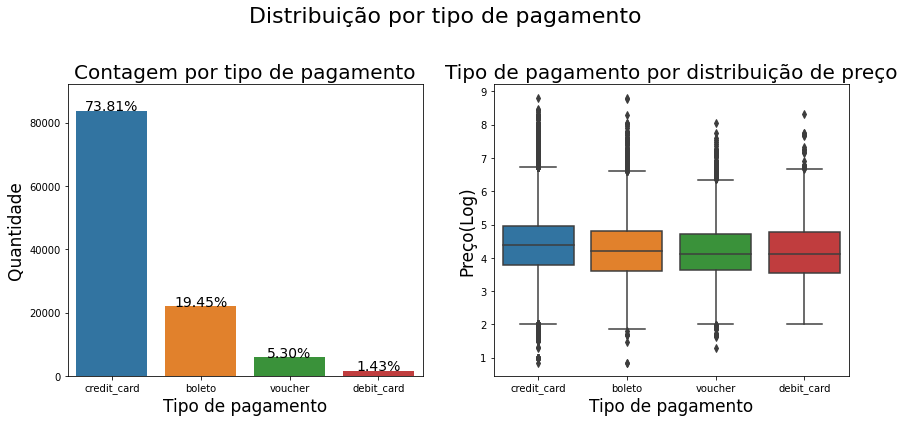

In [91]:
merge_df['price_log'] = np.log(merge_df['price'] + 1.5)

total = len(merge_df)

plt.figure(figsize=(14,6))

plt.suptitle('Distribuição por tipo de pagamento', fontsize=22)

plt.subplot(121)
g = sns.countplot(x='payment_type', data=merge_df[merge_df['payment_type'] != 'not_defined'])
g.set_title("Contagem por tipo de pagamento", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Quantidade", fontsize=17)

sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.1)

plt.subplot(122)
g = sns.boxplot(x='payment_type', y='price_log', data=merge_df[merge_df['payment_type'] != 'not_defined'])
g.set_title("Tipo de pagamento por distribuição de preço", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Preço(Log)", fontsize=17)

plt.subplots_adjust(hspace = 0.5, top = 0.8)

plt.show()

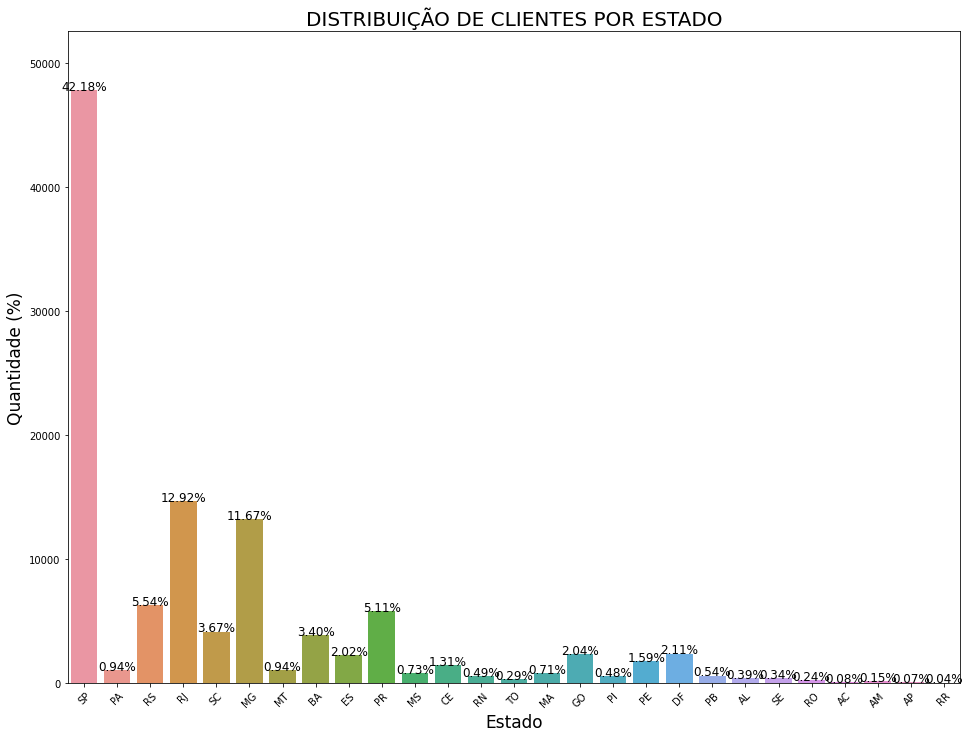

In [92]:
plt.figure(figsize=(16,12))

g = sns.countplot(x='customer_state', data=merge_df, orient='h')
g.set_title("DISTRIBUIÇÃO DE CLIENTES POR ESTADO", fontsize=20)
g.set_xlabel("Estado", fontsize=17)
g.set_ylabel("Quantidade (%)", fontsize=17)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

plt.show()

CALCULO DO VALOR DO FRETE POR REGIAO E ESTADO.
CALCULA-SE A MEDIA DO VALOR DE QUAL REGIAO SERÁ ENVIADO O PRODUTO E QUAL O ESTADO DE DESTINO.

In [93]:
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

merge_df.loc[merge_df['customer_state'].isin(sudeste), 'Regiao do Comprador'] = 'Sudeste'
merge_df.loc[merge_df['customer_state'].isin(nordeste), 'Regiao do Comprador'] = 'Nordeste'
merge_df.loc[merge_df['customer_state'].isin(norte), 'Regiao do Comprador'] = 'Norte'
merge_df.loc[merge_df['customer_state'].isin(centro_oeste), 'Regiao do Comprador'] = 'Centro-Oeste'
merge_df.loc[merge_df['customer_state'].isin(sul), 'Regiao do Comprador'] = 'Sul'

In [94]:
def cross_heatmap(df, cols,normalize=False, values=None, aggfunc=None):
    temp = cols
    cm = sns.light_palette("green", as_cmap=True)
    return pd.crosstab(df[temp[0]], df[temp[1]],  rownames=['Estado do Vendedor'],
                       normalize=normalize, values=values, aggfunc=aggfunc).style.background_gradient(cmap = cm)

In [95]:
cross_heatmap(merge_df[merge_df['price'] != -1], ['seller_state', 'Regiao do Comprador'], 
              values=merge_df[merge_df['price'] != -1]['freight_value'], aggfunc='mean')

Regiao do Comprador,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
Estado do Vendedor,,,,,
AM,nan,28.255000,nan,25.290000,nan
BA,30.273415,22.895625,47.342500,33.642448,40.299467
CE,65.456667,29.290278,85.614000,47.602273,53.125000
DF,12.927647,27.678491,58.371935,19.537642,26.395732
ES,36.895833,37.368039,60.022857,28.796813,40.336800
GO,14.562941,33.571290,26.595909,23.749076,30.641136
MA,27.150192,19.410886,28.859000,31.802922,42.660652
MG,27.095909,34.375710,42.508188,21.153917,29.005198
MS,26.228571,29.412308,21.410000,21.608750,25.600000


ORDEM DE COMPRA DURANTE O DIA

In [146]:
dts = merge_df.copy()

In [154]:
dts.head()

,customer_id,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_id,...,seller_state,payment_type,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase_timestamp2,day_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-25,2017-06-05,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,2017-05-16,Tuesday
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,2017-11-28,2017-12-19,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,2017-11-09,Thursday
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,2017-11-28,2017-12-19,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,2017-11-09,Thursday
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07,2017-05-26,2017-06-12,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,2017-05-07,Sunday
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03,2018-02-28,2018-03-22,a9516a079e37a9c9c36b9b78b10169e8,...,SP,credit_card,moveis_escritorio,1.0,8683.0,54.0,64.0,31.0,2018-02-03,Saturday


In [149]:
dts['order_purchase_timestamp2'] = dts['order_purchase_timestamp']

In [156]:
dts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113405 entries, 0 to 117600
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113405 non-null  object        
 1   customer_unique_id             113405 non-null  object        
 2   customer_city                  113405 non-null  object        
 3   customer_state                 113405 non-null  object        
 4   order_id                       113405 non-null  object        
 5   order_status                   113405 non-null  object        
 6   order_purchase_timestamp       113405 non-null  datetime64[ns]
 7   order_delivered_customer_date  113405 non-null  datetime64[ns]
 8   order_estimated_delivery_date  113405 non-null  datetime64[ns]
 9   product_id                     113405 non-null  object        
 10  seller_id                      113405 non-null  object        
 11  

In [150]:
dts['day_name'] = dts['order_purchase_timestamp'].dt.day_name()

In [28]:
novo_df = dts[['order_purchase_timestamp', 'order_purchase_timestamp2', 'product_category_name']]

In [54]:
dts.set_index('order_purchase_timestamp2', inplace=True)

In [70]:
dts.groupby('day_name').resample('15Min', on = 'order_purchase_timestamp')['customer_id'].nunique().reset_index(name = 'count')

IndexError: index 1516972920000000000 is out of bounds for axis 0 with size 113405

In [56]:
#dts = merge_df.copy()
#dts['day_name'] = dts['order_purchase_timestamp'].dt.day_name()
dts = dts.groupby('day_name').resample('15Min', on = 'order_purchase_timestamp')['order_id'].nunique().reset_index(name = 'count')
dts['purchase_time'] = dts['order_purchase_timestamp'].dt.time
dts['purchase_time'] = pd.to_datetime(dts['purchase_time'],format='%H:%M:%S')
dts = dts.groupby(['purchase_time', 'day_name'])['count'].sum().reset_index(name = 'count')
f, ax = plt.subplots(figsize = (20, 5), dpi = 120)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_title('Order in one day')
day_order = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
sns.lineplot(x = 'purchase_time', y ='count', hue = 'day_name', hue_order = day_order,\
             data = dts, ax = ax, palette = 'rainbow');
f.autofmt_xdate();

IndexError: index 1516972920000000000 is out of bounds for axis 0 with size 113405

In [76]:
dts = dts.groupby('day_name').resample('15Min', on = 'order_purchase_timestamp')['order_id'].nunique().reset_index(name = 'count')
dts['purchase_time'] = dts['order_purchase_timestamp'].dt.time
dts.groupby(['purchase_time', 'day_name'])['count'].sum().reset_index(name = 'count')

AttributeError: 'DatetimeIndexResamplerGroupby' object has no attribute 'reset_index'

In [81]:
new_df = dts.groupby('day_name').resample('15Min', on = 'order_purchase_timestamp').sum()

In [83]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 463548 entries, ('Friday', Timestamp('2016-10-07 00:45:00')) to ('Wednesday', Timestamp('2018-08-29 15:00:00'))
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               463548 non-null  float64
 1   freight_value       463548 non-null  float64
 2   product_photos_qty  463548 non-null  float64
 3   product_weight_g    463548 non-null  float64
 4   product_length_cm   463548 non-null  float64
 5   product_height_cm   463548 non-null  float64
 6   product_width_cm    463548 non-null  float64
 7   price_log           463548 non-null  float64
dtypes: float64(8)
memory usage: 33.0+ MB
